# Convolutional Neural Network

### Part 1 - Building the CNN

#### Importing the Tensorflow libraries and packages

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.4
Scikit-Learn 0.24.1
GPU is available


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import os

In [3]:
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
VALID_DIR = 'dataset/valid'
IMG_SIZE = 224
IMG_RESCALE = 224

##  VGG16

In [4]:
import tensorflow.keras as keras

vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
import matplotlib.pyplot as plt
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        zoom_range = 0.2,
        horizontal_flip = True
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        TRAIN_DIR,
        target_size = (height, width), 
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    val_dataset = imgdatagen.flow_from_directory(
        VALID_DIR,
        target_size = (height, width), 
        batch_size = batch_size,
        class_mode = 'categorical'
    )
    
    test_dataset = imgdatagen.flow_from_directory(
        TEST_DIR,
        target_size = (height, width), 
        batch_size = batch_size,
        class_mode = 'categorical'
    )
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [8]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)

# final softmax layer with 250 categories
predictions = keras.layers.Dense(250, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
for layer in conv_model.layers:
    layer.trainable = False

In [11]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

In [13]:
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=4,
    epochs=20,
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1101 steps, validate for 40 steps
Epoch 1/20
1101/1101 [==============================] - 157s 143ms/step - loss: 3.1504 - acc: 0.3866 - val_loss: 1.0435 - val_acc: 0.7072
Epoch 2/20
1101/1101 [==============================] - 153s 139ms/step - loss: 1.0481 - acc: 0.7361 - val_loss: 0.6615 - val_acc: 0.8272
Epoch 3/20
1101/1101 [==============================] - 153s 139ms/step - loss: 0.6694 - acc: 0.8220 - val_loss: 0.5437 - val_acc: 0.8688
Epoch 4/20
1101/1101 [==============================] - 155s 140ms/step - loss: 0.4999 - acc: 0.8641 - val_loss: 0.5463 - val_acc: 0.8576
Epoch 5/20
1101/1101 [==============================] - 156s 141ms/step - loss: 0.3863 - acc: 0.8918 - val_loss: 0.5846 - val_acc: 0.8840
Epoch 6/20
1101/1101 [==============================] - 155s 141ms/step - loss: 0.3065 - acc: 0.9132 - val_loss: 0.6596 - val_acc: 0.8808
Ep

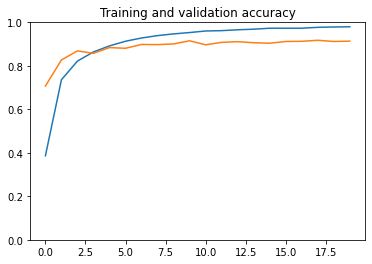

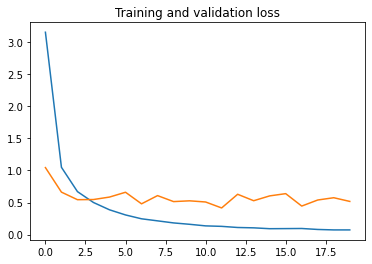

In [14]:
plot_history(history, yrange=(0,1))

In [16]:
score = full_model.evaluate(test_dataset, verbose=0)

print('Test Loss', score[0])
print('Test accuracy', score[1])

  ...
    to  
  ['...']
Test Loss 0.3259444470051675
Test accuracy 0.9336
